# PACKAGES

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import TensorFlow and its components
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers, regularizers


# Import scikit-learn functions for model evaluation and data manipulation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import imbalanced data handling library
from imblearn.over_sampling import RandomOverSampler

# Import Keras utility for model loading
from keras.models import load_model

# Import OpenCV for image processing
import os


# Import Keras utility for one-hot encoding
from keras.utils import to_categorical
import cv2 

ModuleNotFoundError: No module named 'imblearn'

## DATA PREPROCESSING

In [2]:
def load_images_from_folder(folder):
    images = []
    image_extensions = [".jpg", ".jpeg", ".png"]  # Add more extensions if needed

    for filename in os.listdir(folder):
        file_ext = os.path.splitext(filename)[1].lower()
        if file_ext in image_extensions:
            img_path = os.path.join(folder, filename)
            # Load image using OpenCV
            img = cv2.imread(img_path)
            img_r = cv2.resize(img, (100,100))
            if img is not None:
                images.append(img_r)
    return images



# Define folder paths for healthy, bean rust, and angular leaf spot images
healthy_folder = "healthy"
rust_folder = "bean_rust"
angular_folder = "als"


In [3]:
# Load images from each folder
healthy_images = load_images_from_folder(healthy_folder)
print(len(healthy_images))

5284


In [4]:
rust_images = load_images_from_folder(rust_folder)
print("Number of rust images:", len(rust_images))

Number of rust images: 2510


In [5]:
angular_images = load_images_from_folder(angular_folder)
print("Number of angular images:", len(angular_images))

Number of angular images: 2549


In [6]:
# Combine original and augmented images
all_images = np.concatenate([healthy_images, rust_images, angular_images])

# Create corresponding labels for each image
labels = ['healthy'] * len(healthy_images) + ['rust'] * len(rust_images) + ['angular'] * len(angular_images)

# Calculate the number of classes
num_classes = len(np.unique(labels))

# Calculate the minimum test size required to ensure each class has at least one sample in the testing set
min_test_size = 1.0 / num_classes

test_s = 0.34  

print("Number of classes:", num_classes)
print("Test size:", test_s)

Number of classes: 3
Test size: 0.34


In [7]:
np.unique(labels, return_counts=True)

(array(['angular', 'healthy', 'rust'], dtype='<U7'),
 array([2549, 5284, 2510], dtype=int64))

In [8]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=test_s, random_state=42, stratify=labels)

In [9]:
# Flatten and scale the image data
X_train_flattened = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flattened = X_test.reshape(X_test.shape[0], -1) / 255.0

# Ensure that labels are in numerical format for logistic regression
label_map = {'healthy': 0, 'rust': 1, 'angular': 2}
y_train_encoded = np.array([label_map[label] for label in y_train])
y_test_encoded = np.array([label_map[label] for label in y_test])


# LOGISTIC REGRESSION

In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
logistic_regression_model = LogisticRegression(max_iter=5000)

# Train the logistic regression model on the training data
logistic_regression_model.fit(X_train_flattened, y_train_encoded)


LogisticRegression(max_iter=5000)

In [56]:
# Evaluate the logistic regression model on the testing data
test_accuracy_logistic_regression = logistic_regression_model.score(X_test_flattened, y_test_encoded)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8348023891448975


## DECISION CLASSIFIER

In [13]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the decision tree model
decision_tree_model = DecisionTreeClassifier()

# Train the decision tree model on the training data
decision_tree_model.fit(X_train_flattened, y_train_encoded)


DecisionTreeClassifier()

In [14]:
# Evaluate the decision tree model on the testing data
test_accuracy_decision_tree = decision_tree_model.score(X_test_flattened, y_test_encoded)
print("Decision Tree Test Accuracy:", test_accuracy_decision_tree)


Decision Tree Test Accuracy: 0.522035825988058


# RANDOM FOREST 

In [15]:
# Reshape the image data to the original shape
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])


In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest model
random_forest_model = RandomForestClassifier()

# Train the random forest model on the training data
random_forest_model.fit(X_train_reshaped, y_train_encoded)


RandomForestClassifier()

In [17]:
# Evaluate the random forest model on the testing data
test_accuracy_random_forest = random_forest_model.score(X_test_reshaped, y_test_encoded)
print("Random Forest Test Accuracy:", test_accuracy_random_forest)


Random Forest Test Accuracy: 0.6585157804947398


# SIMPLE_CNN MODEL

In [20]:
# Define the CNN architecture
def create_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the simple CNN model
input_shape = (100, 100, 3)
num_classes = 3
simple_cnn_model = create_simple_cnn(input_shape, num_classes)

# Compile the model
simple_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
simple_cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 33856)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [21]:
# Train the simple CNN model
history = simple_cnn_model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test, y_test_encoded))


Epoch 1/30
214/214 [==============================] - 33s 151ms/step - loss: 14.2015 - accuracy: 0.5434 - val_loss: 0.8480 - val_accuracy: 0.5832
Epoch 2/30
214/214 [==============================] - 33s 156ms/step - loss: 0.7736 - accuracy: 0.6333 - val_loss: 0.8886 - val_accuracy: 0.6002
Epoch 3/30
214/214 [==============================] - 33s 156ms/step - loss: 0.5991 - accuracy: 0.7301 - val_loss: 0.9625 - val_accuracy: 0.5860
Epoch 4/30
214/214 [==============================] - 34s 159ms/step - loss: 0.4162 - accuracy: 0.8202 - val_loss: 1.1110 - val_accuracy: 0.5903
Epoch 5/30
214/214 [==============================] - 32s 150ms/step - loss: 0.3188 - accuracy: 0.8639 - val_loss: 1.3337 - val_accuracy: 0.5917
Epoch 6/30
214/214 [==============================] - 36s 169ms/step - loss: 0.2630 - accuracy: 0.8973 - val_loss: 1.6740 - val_accuracy: 0.5926
Epoch 7/30
214/214 [==============================] - 33s 155ms/step - loss: 0.1985 - accuracy: 0.9248 - val_loss: 1.5844 - val_a

In [58]:
# Evaluate the simple CNN model on the testing data
test_loss, test_accuracy_simple_cnn = simple_cnn_model.evaluate(X_test, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy_simple_cnn)


110/110 [==============================] - 3s 31ms/step - loss: 3.5517 - accuracy: 0.6076
Test Loss: 3.5517356395721436
Test Accuracy: 0.607620120048523


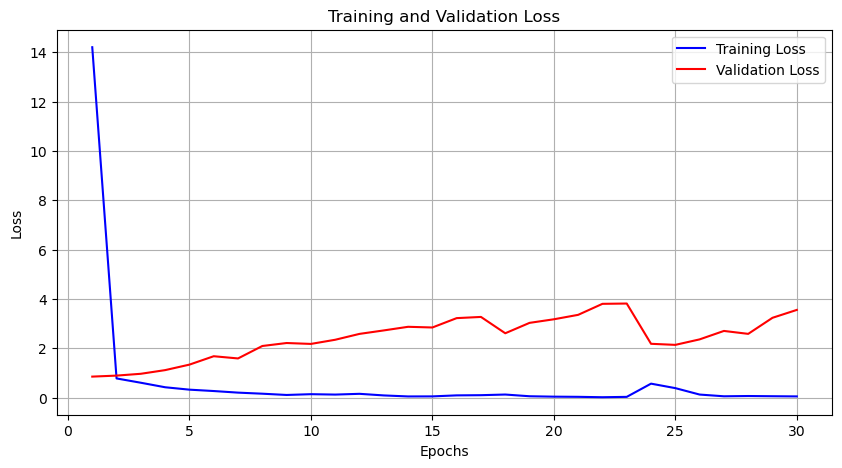

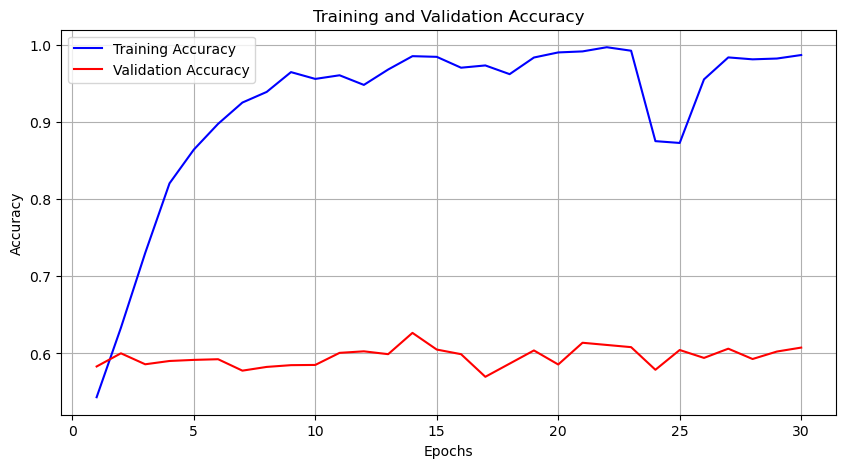

In [23]:
# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## REGULARIZED_CNN MODEL

In [25]:
# Define the CNN architecture with dropout and weight decay
def create_regularized_cnn(input_shape, num_classes, dropout_rate=0.5, weight_decay=1e-4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(weight_decay)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the regularized CNN model
regularized_cnn_model = create_regularized_cnn(input_shape, num_classes)

# Compile the model
regularized_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

regularized_cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 33856)             0         
                                                                 
 dropout_1 (Dropout)         (None, 33856)            

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history_regularized = regularized_cnn_model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, 
                                                validation_data=(X_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/30
214/214 [==============================] - 36s 164ms/step - loss: 20.5334 - accuracy: 0.4856 - val_loss: 1.0814 - val_accuracy: 0.5095
Epoch 2/30
214/214 [==============================] - 35s 165ms/step - loss: 1.0256 - accuracy: 0.5059 - val_loss: 1.0659 - val_accuracy: 0.5033
Epoch 3/30
214/214 [==============================] - 35s 162ms/step - loss: 1.0462 - accuracy: 0.5086 - val_loss: 1.0277 - val_accuracy: 0.5078
Epoch 4/30
214/214 [==============================] - 34s 161ms/step - loss: 0.9935 - accuracy: 0.5094 - val_loss: 1.0217 - val_accuracy: 0.5078
Epoch 5/30
214/214 [==============================] - 35s 163ms/step - loss: 0.9051 - accuracy: 0.5151 - val_loss: 1.0138 - val_accuracy: 0.4956
Epoch 6/30
214/214 [==============================] - 35s 163ms/step - loss: 0.9753 - accuracy: 0.5155 - val_loss: 1.0283 - val_accuracy: 0.5075
Epoch 7/30
214/214 [==============================] - 35s 163ms/step - loss: 0.8697 - accuracy: 0.5678 - val_loss: 0.9144 - val_a

In [59]:
# Evaluate the simple CNN model on the testing data
test_loss, test_accuracy_regularized = regularized_cnn_model.evaluate(X_test, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy_regularized)


110/110 [==============================] - 3s 31ms/step - loss: 0.9107 - accuracy: 0.6019
Test Loss: 0.9106566309928894
Test Accuracy: 0.601933479309082


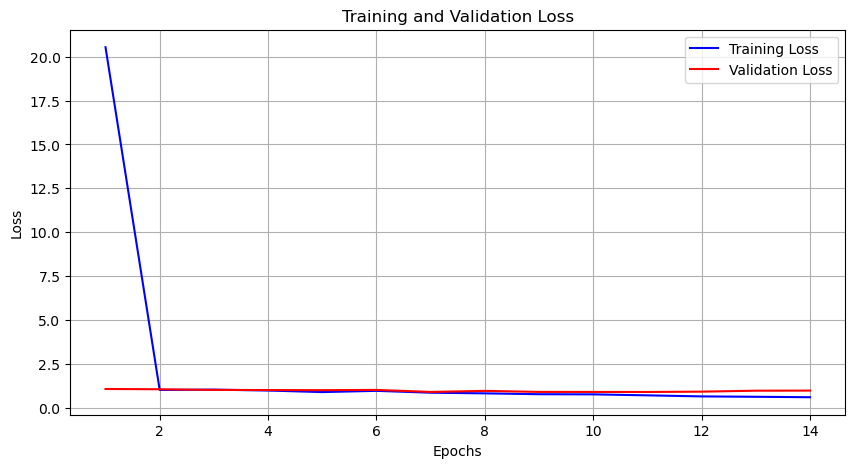

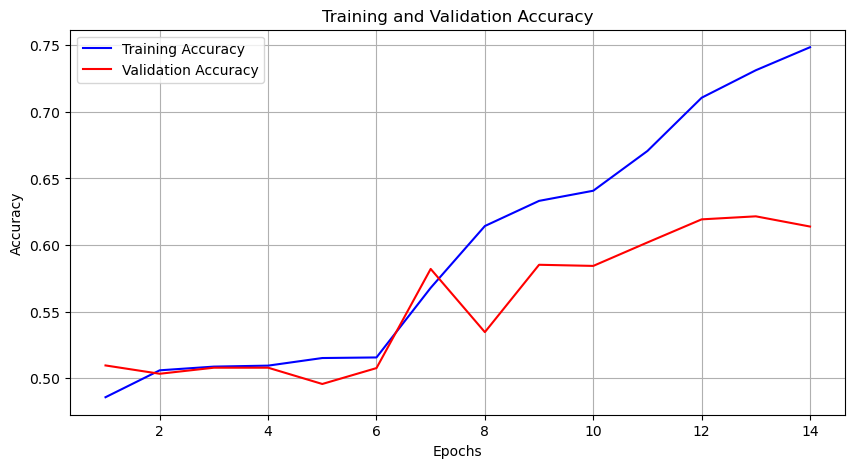

In [29]:
# Get training history
train_loss = history_regularized.history['loss']
val_loss = history_regularized.history['val_loss']
train_accuracy = history_regularized.history['accuracy']
val_accuracy = history_regularized.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## SIMPLE_CNN MODEL EVALUATION

In [34]:
# Get the model predictions on the testing data
y_pred = simple_cnn_model.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)



# Print classification report
print("\nClassification Report:")
print(class_report)

110/110 [==============================] - 4s 32ms/step
Confusion Matrix:
[[1580  144   73]
 [ 349  293  211]
 [ 352  251  264]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.88      0.77      1797
           1       0.43      0.34      0.38       853
           2       0.48      0.30      0.37       867

    accuracy                           0.61      3517
   macro avg       0.53      0.51      0.51      3517
weighted avg       0.58      0.61      0.58      3517



## REGULARIZED_CNN MODEL EVALUATION

In [35]:
# Get the model predictions on the testing data
y_pred = regularized_cnn_model.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(class_report)

110/110 [==============================] - 5s 45ms/step
Confusion Matrix:
[[1446  213  138]
 [ 169  482  202]
 [ 231  447  189]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1797
           1       0.42      0.57      0.48       853
           2       0.36      0.22      0.27       867

    accuracy                           0.60      3517
   macro avg       0.52      0.53      0.52      3517
weighted avg       0.59      0.60      0.59      3517



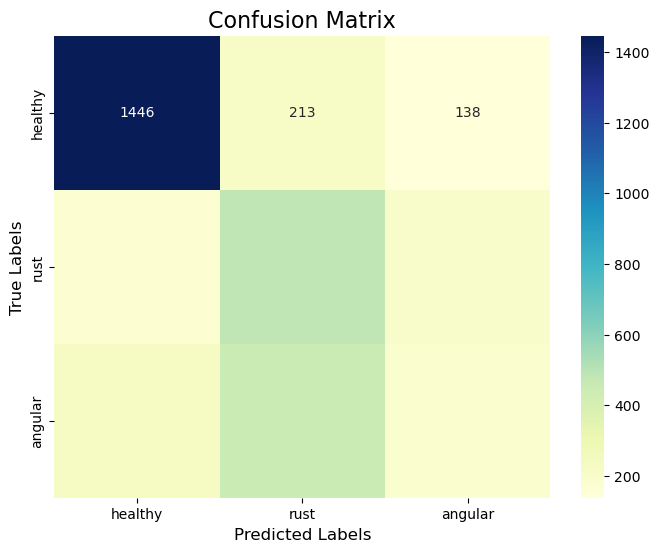

In [48]:
# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted Labels',fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()


### RESNET MODEL ARCHITECTURE

In [50]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the pre-trained model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the ResNet model with early stopping
history_resnet = resnet_model.fit(X_train, y_train_encoded, epochs=30, batch_size=32,
                                  validation_data=(X_test, y_test_encoded),
                                  callbacks=[early_stopping])


Epoch 1/30
214/214 [==============================] - 119s 542ms/step - loss: 0.5432 - accuracy: 0.7709 - val_loss: 0.4795 - val_accuracy: 0.7902
Epoch 2/30
214/214 [==============================] - 115s 537ms/step - loss: 0.3718 - accuracy: 0.8393 - val_loss: 0.4197 - val_accuracy: 0.8109
Epoch 3/30
214/214 [==============================] - 117s 549ms/step - loss: 0.3008 - accuracy: 0.8766 - val_loss: 0.4090 - val_accuracy: 0.8266
Epoch 4/30
214/214 [==============================] - 116s 543ms/step - loss: 0.2546 - accuracy: 0.8944 - val_loss: 0.3843 - val_accuracy: 0.8348
Epoch 5/30
214/214 [==============================] - 115s 538ms/step - loss: 0.2121 - accuracy: 0.9120 - val_loss: 0.4761 - val_accuracy: 0.8081
Epoch 6/30
214/214 [==============================] - 118s 555ms/step - loss: 0.1804 - accuracy: 0.9292 - val_loss: 0.4416 - val_accuracy: 0.8229
Epoch 7/30
214/214 [==============================] - 116s 541ms/step - loss: 0.1456 - accuracy: 0.9445 - val_loss: 0.4300 -

In [60]:
test_loss, test_accuracy_resnet = resnet_model.evaluate(X_test, y_test_encoded)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy_resnet)

110/110 [==============================] - 43s 389ms/step - loss: 0.3843 - accuracy: 0.8348
Test Loss: 0.38433530926704407
Test Accuracy: 0.8348023891448975


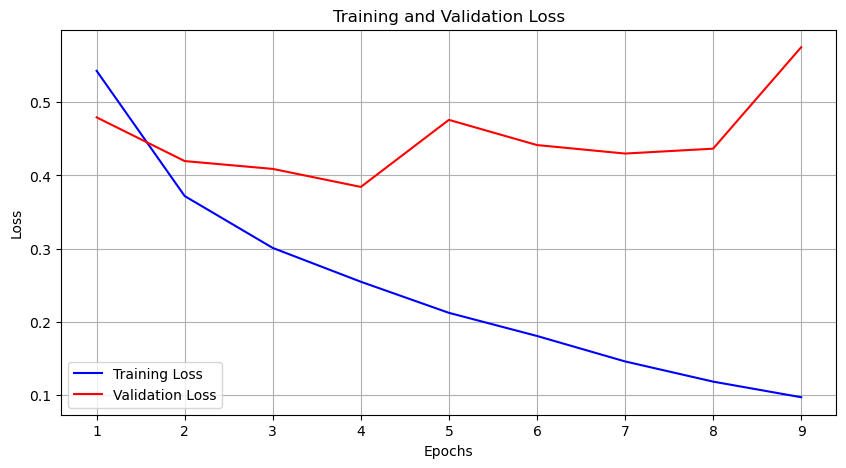

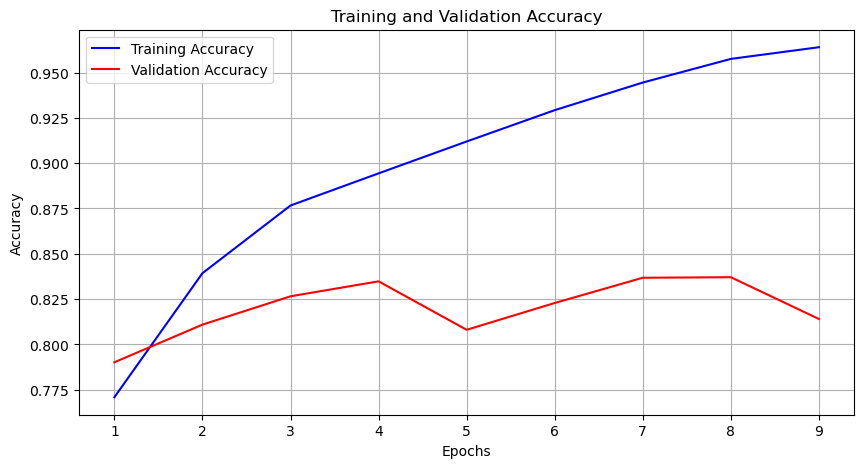

In [54]:
# Get training history
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



In [55]:
# Get the model predictions on the testing data
y_pred = resnet_model.predict(X_test)
# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_labels)

# Generate classification report
class_report = classification_report(y_test_encoded, y_pred_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(class_report)

110/110 [==============================] - 42s 368ms/step
Confusion Matrix:
[[1732   38   27]
 [  70  570  213]
 [  56  177  634]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1797
           1       0.73      0.67      0.70       853
           2       0.73      0.73      0.73       867

    accuracy                           0.83      3517
   macro avg       0.79      0.79      0.79      3517
weighted avg       0.83      0.83      0.83      3517



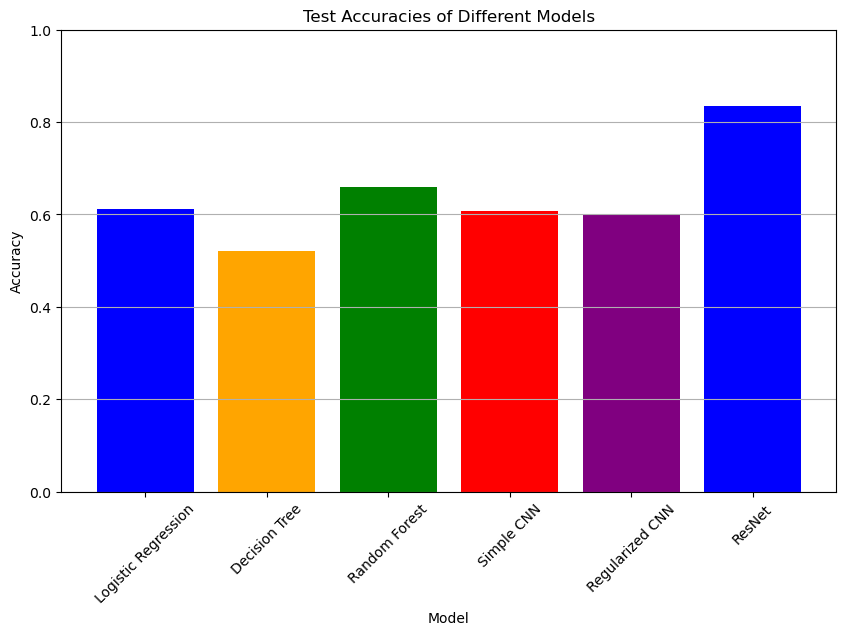

In [61]:
import matplotlib.pyplot as plt

# Test accuracies of all models
test_accuracies = [test_accuracy_logistic_regression, test_accuracy_decision_tree, test_accuracy_random_forest, test_accuracy_simple_cnn,test_accuracy_regularized, test_accuracy_resnet]

# Names of the models
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Simple CNN','Regularized CNN', 'ResNet']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(model_names, test_accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Test Accuracies of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to be between 0 and 1
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
